In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd

In [55]:
synthesizers = dict()
epochs=10
synthesizers['tablegan'] = TableganSynthesizer(store_epoch=[epochs])
synthesizers['tgan'] = TGANSynthesizer(store_epoch=[epochs])
synthesizers['medgan'] = MedganSynthesizer(store_epoch=[epochs], pretrain_epoch=50)

In [57]:
for key, value in synthesizers.items():
    print(key, value)

tablegan <sdgym.synthesizers.tablegan.TableganSynthesizer object at 0x7f59e0b3c0b8>
tgan <sdgym.synthesizers.tgan.TGANSynthesizer object at 0x7f59e0b3c0f0>
medgan <sdgym.synthesizers.medgan.MedganSynthesizer object at 0x7f59e0b3c160>


In [40]:
from sdgym.synthesizers.tgan import *
from sdgym.synthesizers.tablegan import *
from sdgym.synthesizers.medgan import *

# from synthetic_data_benchmark.synthesizer.tgan_synthesizer import *
# from synthetic_data_benchmark.synthesizer.tablegan_synthesizer import *

import pandas as pd
import numpy as np
import json
from tqdm.auto import tqdm

import configparser
config = configparser.ConfigParser()
config.read('config.ini')

output = 'samples/test'
dataset = 'berka'
working_dir = "{}/ckpt_{}".format(output, dataset)

# data = pd.read_csv('../data/berka/berka.csv', sep=';')[:1000000]
data = pd.read_csv('../data/berka/berka_sdgym.csv')

# import pickle
# subs = pickle.load(open('../data/berka/subs.pkl', 'rb'))

# meta = [
#     {
#     'name': 'account_id',
#     'type': 'continuous',
#     'min': data.account_id.min(),
#     'max': data.account_id.max()
#     },
# #     {
# #     'name': 'account_id',
# #     'type': 'categorical',
# #     'size': len(data.account_id.unique().tolist()),
# #     'i2s': subs['account_id']['label'].values.tolist()
# #     },
#     {
#     'name': 'trans_amount',
#     'type': 'continuous',
#     'min': data.trans_amount.min(),
#     'max': data.trans_amount.max()   
#     },
#     {
#     'name': 'balance_after_trans',
#     'type': 'continuous',
#     'min': data.balance_after_trans.min(),
#     'max': data.balance_after_trans.max()    
#     },
#     {
#     'name': 'trans_type',
#     'type': 'categorical',
#     'size': 3,
#     'i2s': ['CREDIT', 'WITHDRAWAL', 'UNKNOWN']    
#     },
#     {
#     'name': 'trans_operation',
#     'type': 'categorical',
#     'size': 6,
#     'i2s': subs['trans_operation']['label'].values.tolist()    
#     },
# #     {
# #     'name': 'trans_date',
# #     'type': 'ordinal',
# #     'size': len(data.trans_date.unique().tolist()),
# #     'i2s': list(range(data.trans_date.max()))    
# #     },
#     {
#     'name': 'trans_date',
#     'type': 'continuous',
#     'size': data.trans_date.min(),
#     'i2s': data.trans_date.max()    
#     },
# ]

meta = json.load(open('data/real/berka.json', 'r'))

synthesizer = TableganSynthesizer(store_epoch=[100])
# synthesizer = MedganSynthesizer(store_epoch=[100], pretrain_epoch=5)
synthesizer.init(meta, working_dir)


In [ ]:
# cometml_key=config['comet_ml']['api_key']
synthesizer.train(data.values)

In [10]:
for i, y in synthesizer.generator.named_parameters():
    print(i, y)

AttributeError: 'TGANSynthesizer' object has no attribute 'generator'

In [220]:
act_means = [[] for _ in synthesizer.generator.seq]
act_stds  = [[] for _ in synthesizer.generator.seq]

In [195]:
def append_stats(i):
    def hook(mod, inp, outp):
        act_means[i].append(outp.data.mean())
        act_stds [i].append(outp.data.std())
    return hook

In [196]:
from functools import partial
for i, m in enumerate(synthesizer.generator.seq): m.register_forward_hook(append_stats(i))


In [199]:
act_means

[[tensor(nan, device='cuda:0'),
  tensor(nan, device='cuda:0'),
  tensor(nan, device='cuda:0')],
 [tensor(nan, device='cuda:0'),
  tensor(nan, device='cuda:0'),
  tensor(nan, device='cuda:0')],
 [tensor(nan, device='cuda:0'),
  tensor(nan, device='cuda:0'),
  tensor(nan, device='cuda:0')]]

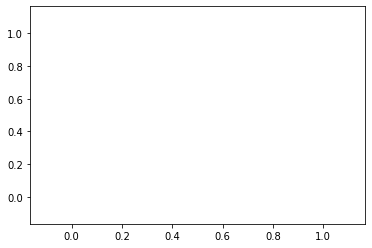

In [198]:
import matplotlib.pyplot as plt
for l in act_means: plt.plot(l)


In [197]:
n = 1000
generated = synthesizer.generate(n)


In [174]:
z = pd.DataFrame(generated[0][1])
z.columns = data.columns
z.head()

,account_id,trans_amount,balance_after_trans,trans_type,trans_operation,trans_date
0,215.900912,20486.589735,25186.654534,0.0,3.0,189.0
1,21.312649,-477.730918,22048.833255,0.0,2.0,101.0
2,69.479179,31020.134045,24513.288084,0.0,1.0,201.0
3,150.171570,8227.723997,36425.347746,2.0,0.0,187.0
4,160.459434,711.122546,45111.946315,0.0,5.0,73.0


In [ ]:
sample = min(args.sample, data.shape[0])
generated = synthesizer.generate(sample)

In [8]:
b = pd.read_csv('../data/berka/berka.csv', sep=';')
b.head()

,account_id,trans_amount,balance_after_trans,trans_type,trans_operation,trans_date
0,0,700.0,700.0,0,0,0
1,1,900.0,900.0,0,0,0
2,2,1000.0,1000.0,0,0,0
3,3,600.0,600.0,0,0,0
4,4,400.0,400.0,0,0,1


In [10]:
for col in b._get_numeric_data().columns:
    print(b[col].min(), b[col].max())

0 4499
0.0 87400.0
-41125.7 209637.0
0 2
0 5
0 2190


In [175]:
import pickle
subs = pickle.load(open('../data/berka/subs.pkl', 'rb'))

In [176]:
subs.keys()

dict_keys(['trans_operation', 'account_id', 'trans_type'])

In [5]:
from sdgym.synthesizers.tgan import *
from sdgym.synthesizers.tablegan import *
from sdgym.synthesizers.medgan import *
import pandas as pd
import numpy as np
import json
from comet_ml import Experiment
import configparser
import argparse


In [5]:
# parser = argparse.ArgumentParser(description='Evaluate data synthesizers')
# parser.add_argument('--dataset', type=str, help='Which dataset to choose. Options are berka, creditcard and ticket')
# parser.add_argument('--synthesizers', nargs='*', help='Which synthesizers/generators to use.', default=['tablegan', 'tgan', 'medgan'])

# args = parser.parse_args()
# dataset = args.dataset
# arg_synths = args.synthesizers

dataset = 'creditcard'
arg_synths = ['tablegan']

config = configparser.ConfigParser()
config.read('config.ini')

output = 'samples/test'
working_dir = "{}/ckpt_{}".format(output, dataset)
epochs = 100
n = 100000
project_name = "dsgym-tgan"

data = pd.read_csv(f'../data/{dataset}/{dataset}_sdgym.csv')
meta = json.load(open(f'data/real/{dataset}.json', 'r'))

print(f'\nDataset: {dataset} \nEpochs: {epochs}\n')

synthesizers = dict()
if 'tablegan' in arg_synths:
    synthesizers['tablegan'] = TableganSynthesizer(store_epoch=list(range(1, epochs, 10)))
if 'tgan' in arg_synths:
    synthesizers['tgan'] = TGANSynthesizer(store_epoch=[50, epochs])
if 'medgan' in arg_synths:
    synthesizers['medgan'] = MedganSynthesizer(store_epoch=list(range(epochs)), pretrain_epoch=50)

for synth_name, synthesizer in synthesizers.items():
    synthesizer.init(meta, working_dir)

    experiment = Experiment(api_key=config['comet_ml']['api_key'],
                            project_name=project_name, workspace="baukebrenninkmeijer")
    experiment.log_parameter('dataset', dataset)

    print(f'Training {synth_name}')
    synthesizer.train(data.values, experiment=experiment)

    generated = synthesizer.generate(n)

    z = pd.DataFrame(generated[0][1])
    z.columns = data.columns
    data_path = f'generated_data/{dataset}/{synth_name}'
    if not os.path.exists(data_path):
        os.mkdir(data_path)
    z.to_csv(f'{data_path}/sample_{dataset}_{epochs}.csv', index=False)
    experiment.end()
    print('Done.')

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/baukebrenninkmeijer/dsgym-tgan/b244957c645e4bbda31f8056e1bd9570
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Discriminator Loss [117]     : (0.2934846878051758, 1.5544346570968628)
COMET INFO:     Generator Loss [117]         : (0.1598927080631256, 3.1020915508270264)
COMET INFO:     loss [361]                   : (0.27679598331451416, 14.723712921142578)
COMET INFO:     sys.gpu.0.free_memory [5]    : (9967960064.0, 10056040448.0)
COMET INFO:     sys.gpu.0.gpu_utilization [5]: (80.0, 93.0)
COMET INFO:     sys.gpu.0.total_memory       : (11996954624.0, 11996954624.0)
COMET INFO:     sys.gpu.0.used_memory [5]    : (1940914176.0, 2028994560.0)
COMET INFO: ----------------------------



Dataset: creditcard 
Epochs: 100



COMET INFO: old comet version (2.0.1) detected. current: 2.0.2 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/baukebrenninkmeijer/dsgym-tgan/e9c1bc62b0c0439b900efacb764d1f85



Training tablegan
epoch 1 step 10 tensor(0.6284, device='cuda:0', grad_fn=<SubBackward0>) tensor(1.2242, device='cuda:0', grad_fn=<NegBackward>) None
epoch 1 step 20 tensor(0.3757, device='cuda:0', grad_fn=<SubBackward0>) tensor(1.8269, device='cuda:0', grad_fn=<NegBackward>) None
epoch 1 step 30 tensor(0.2379, device='cuda:0', grad_fn=<SubBackward0>) tensor(2.3447, device='cuda:0', grad_fn=<NegBackward>) None
epoch 1 step 40 tensor(0.2755, device='cuda:0', grad_fn=<SubBackward0>) tensor(2.2180, device='cuda:0', grad_fn=<NegBackward>) None
epoch 1 step 50 tensor(0.5719, device='cuda:0', grad_fn=<SubBackward0>) tensor(1.6203, device='cuda:0', grad_fn=<NegBackward>) None
epoch 1 step 60 tensor(0.5222, device='cuda:0', grad_fn=<SubBackward0>) tensor(1.6409, device='cuda:0', grad_fn=<NegBackward>) None
epoch 1 step 70 tensor(0.4664, device='cuda:0', grad_fn=<SubBackward0>) tensor(1.5840, device='cuda:0', grad_fn=<NegBackward>) None
epoch 1 step 80 tensor(0.4760, device='cuda:0', grad_fn=<S

KeyboardInterrupt: 